## Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from Modules.muon import Muon
from Modules.positron import Positron
import Modules.functions as func

from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

## Aligned muons decaying in uniform field
Change the p.phase line for aligned or random phase muons

Generates N particles and sorts by lifetime

In [5]:
N = 100000
field_strength = 0.001
particles = [Muon() for _ in range(N)]

for p in particles:
    p.revs = p.get_decay_orientation(field_strength)  # returns values {0, 2pi}
    #p.phase = np.random.uniform(0, 2*np.pi)
    p.phase = 0
    p.decay_angle = np.sin((p.revs + p.phase) % (2*np.pi))
    p.polarisation = p.get_spin_polarisation(field_strength, np.pi/2)
particles.sort(key=lambda x: x.lifetime)

### Asymmetry
$A = a_0 \cos{(\omega t)}$

In [6]:
def count_asym(a0, omega, t):
    return a0 * np.cos(omega*t)

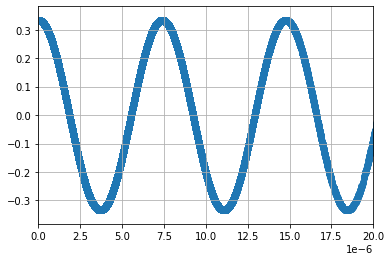

In [7]:
asym = list()
times = [p.lifetime for p in particles]
for p in particles:
    p.asym = count_asym(1/3, func.larmor_freq(field_strength), p.lifetime)
    asym.append(p.asym)
plt.figure()
plt.scatter(times, asym)

#Formatting
plt.xlim(0, 20e-6)
plt.grid()
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.show()
plt.show()

#### Plot of angle against decay time
Decay angle is a value [0, 2pi] for muons depending on larmor frequency and lifetime.

Attempting to recreate this image
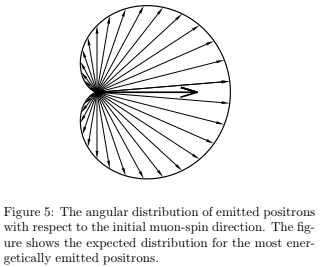

/home/josh/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # Remove the CWD from sys.path while we load stuff.


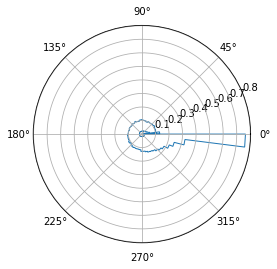

In [8]:
life = np.zeros(len(particles))
decay_angle = np.zeros(len(particles))
time_array = np.linspace(0, 200e-6, 10000)
for i, particle in enumerate(particles):
    #life[i] = particle.lifetime
    decay_angle[i] = particle.decay_angle * 2*np.pi

fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.hist(decay_angle, bins=100, normed=True, histtype="step")
#plt.xlim(0, 20e-6)
#plt.grid()
#plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.show()


#### Histogram of decay times

In [9]:
def expon(x, A, k):
    return A*np.exp(x*k)

<Figure size 432x288 with 0 Axes>

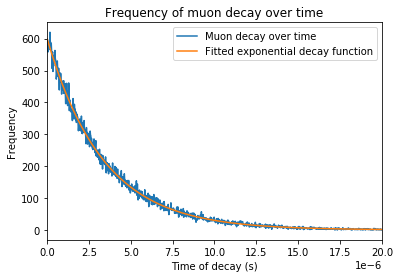

In [10]:
lifetimes = np.array([i.lifetime for i in particles])
bins = np.linspace(0, 20e-6, 1000)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])


frequency, bins, _ = plt.hist(lifetimes, bins=bins, range=(0, 20e-6))
plt.clf()
popt, cpov = curve_fit(expon, binscenters, frequency)

plt.figure()
plt.plot(binscenters, frequency, label="Muon decay over time")
plt.plot(binscenters, expon(binscenters, *popt), label="Fitted exponential decay function")
plt.xlabel("Time of decay (s)")
plt.ylabel("Frequency")
plt.xlim(0, 20e-6)
plt.legend(loc="best")
plt.title("Frequency of muon decay over time")
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.show()

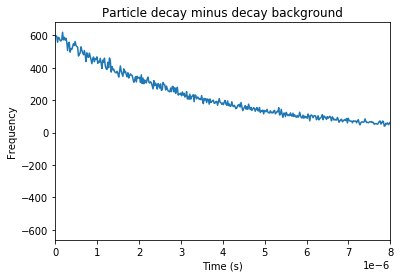

In [11]:
oscillation = [x-y for x, y in zip(frequency, expon(frequency, *popt))]
plt.figure()
plt.plot(binscenters, oscillation)
plt.xlim(0, 8e-6)
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.xlabel("Time (s)")
plt.ylabel("Frequency")
plt.title("Particle decay minus decay background")
plt.show()

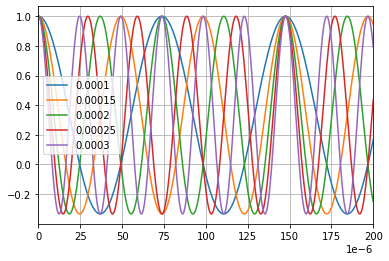

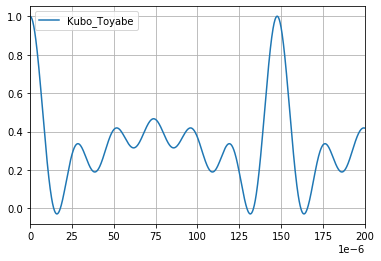

In [27]:
def get_spin_relaxation(field, time, gyro):
    return (1/3) + ((2/3)*(np.cos(gyro * time * field)))

def gaussian_field(width, field):
    term1 = (Muon().gyro_ratio) / (((2*np.pi)**0.5) * width)
    term2 = np.exp( ((-Muon().gyro_ratio)**2) * (field**2) / (2*(width**2)))
    return term1 * term2

# Initiallising variables
N = 1000
particles = [Muon() for _ in range(N)]
fields = [0.0001, 0.00015, 0.0002, 0.00025, 0.0003]
widths = [0.01, 0.1, 0.5, 1]
times =  np.linspace(0, 200e-6, N)

angles = np.zeros([5, N])
angle_average = np.zeros(N)

# Creating data for different field strengths
for i, strength in enumerate(fields):
    for j, t in enumerate(times):
        angles[i][j] = get_spin_relaxation(strength, t, Muon.gyro_ratio)

# Plotting field strength graphs
plt.figure()
for i in range(5):
    plt.plot(times, angles[i], label="{}".format(fields[i]))
    angle_average = np.add(angles[i], angle_average)
plt.legend(loc="best")
plt.xlim(0, 200e-6)
plt.grid()
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.show()

# Plotting average graph
plt.figure()
angle_average = [i/5 for i in angle_average]
plt.plot(times, angle_average, label="Kubo_Toyabe")

plt.legend(loc="best")
plt.xlim(0, 200e-6)
plt.grid()
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.show()

#### KUBO-TOYABE FUNCTION

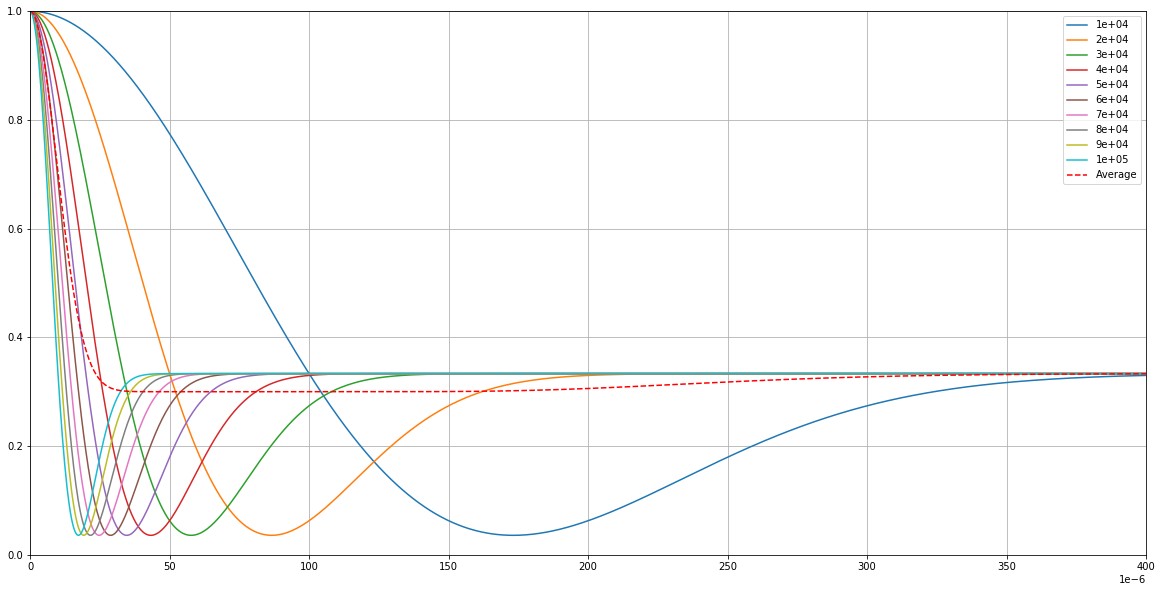

In [72]:
def get_kubo_toyabe_factor(parameter, t):
    return (1/3) + ( (2/3) * (1-((parameter**2) * (t**2))) * np.exp(-0.5*(parameter**2)*(t**2)) )

# Initiallising variables
N = 1000
particles = [Muon() for _ in range(N)]
fields = [0.001, 0.0015, 0.002, 0.0025, 0.003]
widths = np.linspace(1e4, 1e5, 10)
times =  np.linspace(0, 400e-6, N)

polar_av = np.zeros(N)
polarisation = np.zeros([len(widths), N])

for i, w in enumerate(widths):
    for j, t in enumerate(times):
        polarisation[i][j] = get_kubo_toyabe_factor(w, t)
    polar_av = np.add(polar_av, polarisation[i]/len(widths))
        
# Plotting
plt.figure()
for increment, param in enumerate(widths):
    plt.plot(times, polarisation[increment,:], label="{:.0e}".format(param))
    
plt.plot(times, polar_av, "--r", label="Average")
# Plot formatting
plt.legend(loc="best")
plt.xlim(0, 400e-6)
plt.ylim(0, 1)
plt.grid()
plt.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.rcParams["figure.figsize"] = (20,10)
plt.show()